In [13]:
import pandas as pd
import numpy as np
import sys
import os

# 添加mysystem文件夹的路径到sys.path
sys.path.append('mysystem')
from backtest import backtest
from indicate import indicate

# 导入库可能会报错，因为有公共的 backtest 库，若报错，建议将backtest库改名，或者删除公共的backtest库（pip uninstall backtest）

In [14]:
data_path = os.path.join('..', 'data', 'stk_daily.feather')
#若数据为其他数据，需要更改 data_path


data=pd.read_feather(data_path)
data['date']=pd.to_datetime(data['date'])
data.set_index(['stk_id', 'date'], inplace=True)

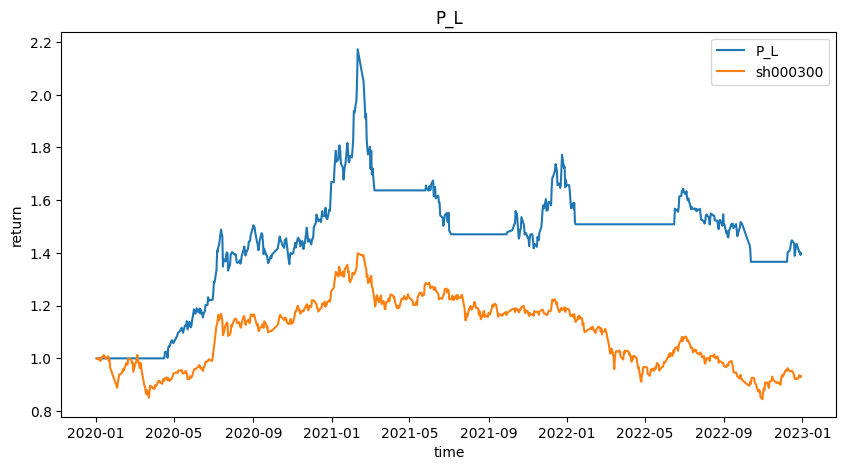

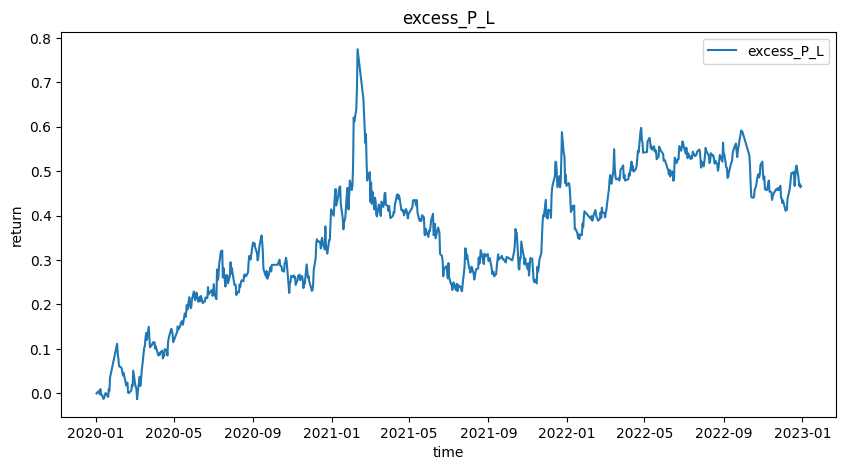

return_rate_year: 0.1408
volatility_year: 0.2207
sharp_ratio: 0.5168
max_drawdown: 0.8064


In [15]:
price=data.loc['600519.SH']['close']
#生成指标
ind=indicate.MACD(price)
#依靠指标生成买卖信号
cos=backtest.signal(ind,buy_sig=30,sell_sig=-30)
#计算P&L
P_L=backtest.crosssection(cos,price)
#分析
backtest.evaluate(P_L)
#注意：计算P_L需要联网


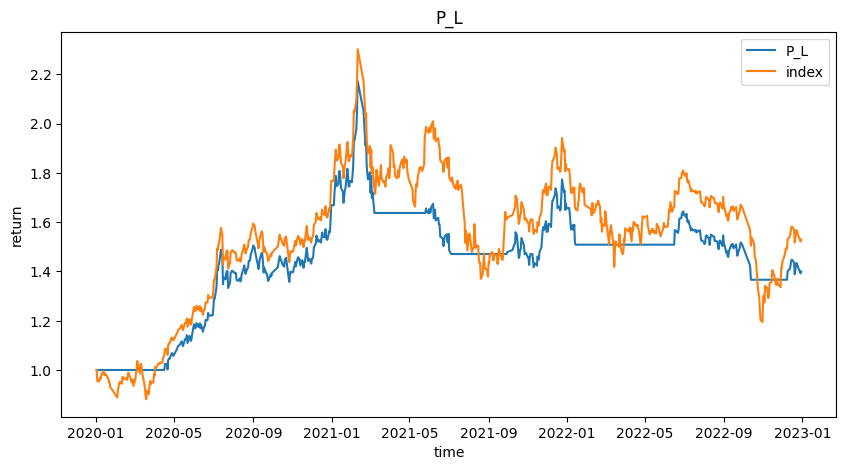

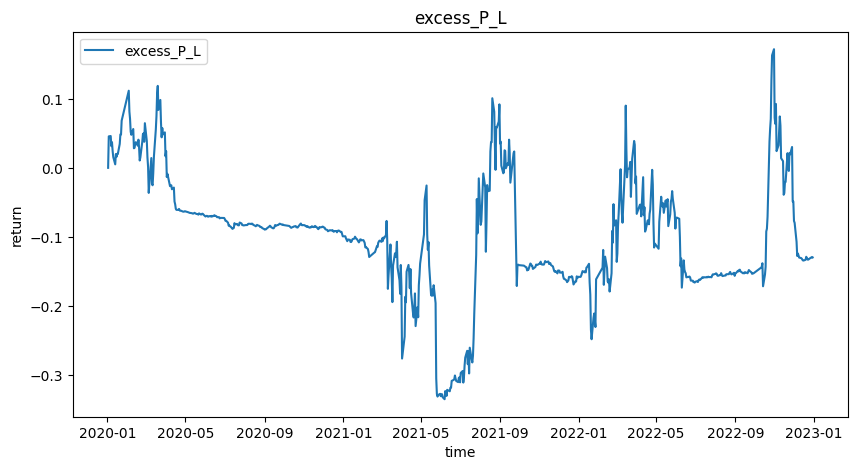

return_rate_year: 0.1408
volatility_year: 0.2207
sharp_ratio: 0.5168
max_drawdown: 0.8064


In [16]:
#benchmark不一定选择指数，可以是任意数据（默认是沪深300）
backtest.evaluate(P_L,index=price)

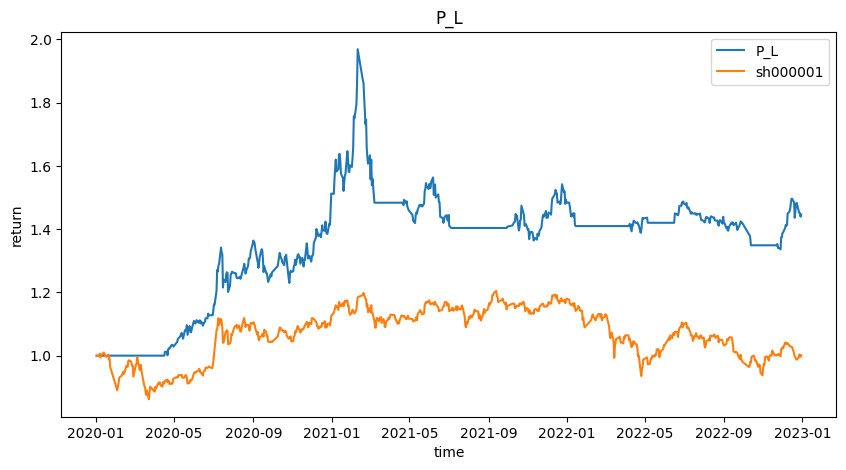

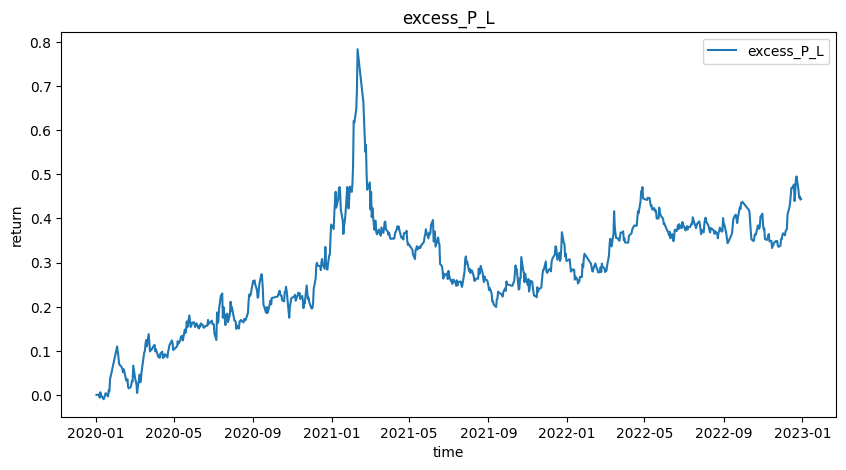

return_rate_year: 0.1467
volatility_year: 0.194
sharp_ratio: 0.6186
max_drawdown: 0.6327


In [17]:
#也可以同时对多个股票合成的P&L进行分析
price_1=data.loc['600519.SH']['close']
price_2=data.loc['000001.SZ']['close']

ind_1=indicate.MACD(price_1)
cos_1=backtest.signal(ind_1,buy_sig=30,sell_sig=-30)
P_L_1=backtest.crosssection(cos_1,price_1)

ind_2=indicate.MACD(price_2)

cos_2=backtest.signal(ind_2,buy_sig=0.1,sell_sig=-0.1)
P_L_2=backtest.crosssection(cos_2,price)

P_L_sum=0.5*P_L_1+0.5*P_L_2

backtest.evaluate(P_L_sum,index='sh000001')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 5
[LightGBM] [Info] Start training from score 0.002373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

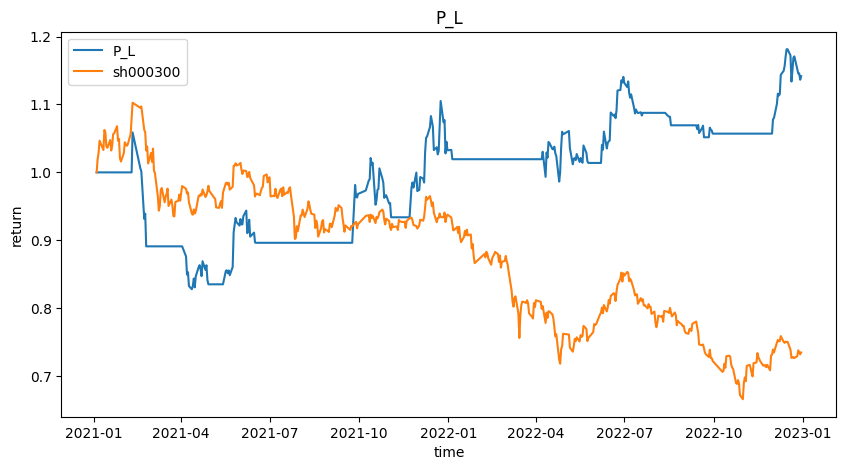

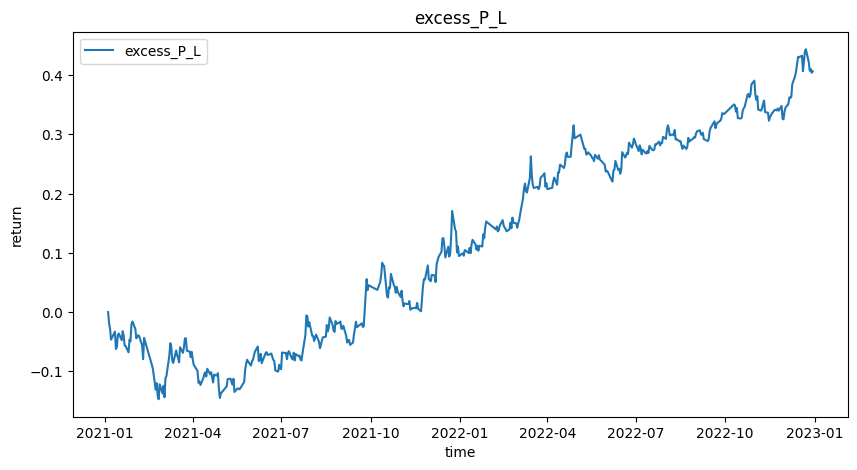

return_rate_year: 0.0886
volatility_year: 0.1986
sharp_ratio: 0.3117
max_drawdown: 0.2308


In [18]:
#也可以使用机器学习合成信号

import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor(
        objective='regression',
        num_leaves=35,
        learning_rate=0.025,
        n_estimators=100,
        class_weight=None
    )

price=data.loc['600519.SH']['close']

price_sample=price.loc[:'2020-12-31']
price_test=price.loc['2021-01-02':]

y=price_sample.pct_change()
y=y.shift(1)

#区分样本集以及测试集
x_sample=pd.DataFrame(index=price_sample.index)
x_test=pd.DataFrame(index=price_test.index)
# 获取 MyClass 的所有方法
classmethod_names = [func for func in dir(indicate) if callable(getattr(indicate, func)) and not func.startswith("__")]

# 遍历并调用每个方法
for method_name in classmethod_names:
    method = getattr(indicate, method_name)
    if callable(method):
        x_sample[method_name]=method(price_sample)
        x_test[method_name]=method(price_test)


#使用Lightgbm合成信号

lgb_reg.fit(x_sample, y)

#在测试集合成信号
ind=lgb_reg.predict(x_test)

ind=pd.DataFrame(ind,columns=['ind'],index=x_test.index)

#当预测收益率大于1%买入，小于1%时卖出
cos=backtest.signal(ind['ind'],buy_sig=0.01,sell_sig=-0.01)
P_L=backtest.crosssection(cos,price_test)

backtest.evaluate(P_L)

